# ANN with mlflow integration 

In [51]:
import keras
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import mlflow
from mlflow.models import infer_signature 

In [52]:
data=pd.read_csv('https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv',sep=';')
print(data.head())
print(data['quality'].unique())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.0              0.27         0.36  ...       0.45      8.8        6
1            6.3              0.30         0.34  ...       0.49      9.5        6
2            8.1              0.28         0.40  ...       0.44     10.1        6
3            7.2              0.23         0.32  ...       0.40      9.9        6
4            7.2              0.23         0.32  ...       0.40      9.9        6

[5 rows x 12 columns]
[6 5 7 8 4 3 9]


In [53]:
# split the data into traning and test 
train,test=train_test_split(data,test_size=0.25,random_state=43)

In [54]:
trainx=train.drop(columns=['quality'],axis=1).values
trainy=train['quality'].values.ravel()

testx=test.drop(columns=['quality'],axis=1).values
testy=test['quality'].values.ravel()

trainx,validx,trainy,validy=train_test_split(trainx,trainy,test_size=0.2,random_state=42)
print(trainx.shape,validx.shape,trainy.shape,validy.shape)

signature=infer_signature(trainx,trainy)

(2938, 11) (735, 11) (2938,) (735,)


## create ANN model

In [55]:
def train_model(params,epochs,trainx,trainy,validx,validy,testx,testy):
    ## define the model architecture 
    mean=np.mean(trainx,axis=0)
    var=np.var(trainx,axis=0)

    model=keras.Sequential(
        [
            keras.Input([trainx.shape[1]]),
            keras.layers.Normalization(mean=mean,variance=var),
            keras.layers.Dense(64,activation='relu'),
            keras.layers.Dense(1)
        ]
    )
     # compile the model 
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params['lr'],momentum=params['momentum']
    ),
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # train the model with lr params and momentum params with MLFLow tracking 
    with mlflow.start_run(nested=True):
        model.fit(trainx,trainy,validation_data=(validx,validy),
                  epochs=epochs,
                  batch_size=64
                  )
   

        #model evaluation 
        eval_result=model.evaluate(validx,validy,batch_size=64)
        eval_rmse=eval_result[1]

        # log the results 
        mlflow.log_params(params)
        mlflow.log_metric('eval_rmse',eval_rmse)

        # logging the model 
        mlflow.tensorflow.log_model(model,'model',signature=signature)
        return {'loss':eval_rmse,'status':STATUS_OK,'model':model}


In [56]:
## create hyperopt objective function 
def objective(params):
    result=train_model(
        params,
        epochs=3,
        trainx=trainx,
        trainy=trainy,
        validx=validx,
        validy=validy,
        testx=testx,
        testy=testy
    )
    return result


In [57]:
space={
    'lr':hp.loguniform('lr',np.log(1e-5),np.log(1e-1)),
    'momentum':hp.uniform('momentum',0.0,1.0)
}

In [58]:
mlflow.set_experiment('win-quality-test')
with mlflow.start_run():
    # conduct the hyperparameter search using Hyperopt
    trials=Trials()     # stores the result of hyperparameter tuning trails
    best=fmin(
        fn=objective,       # minimized the function 
        space=space,        # hyper parameters 
        algo=tpe.suggest,   # hyper parameter optimization - find the optimal set of parameters
        max_evals=4,        # max number of trials 
        trials=trials       # records the outcome
    )

    # fetch the details of the best model
    best_run=sorted(trials.results, key=lambda x:x['loss'])[0]

    # log thr best parameters, loss, and models 
    mlflow.log_params(best)
    mlflow.log_metric('eval_rmse',best_run['loss'])
    mlflow.tensorflow.log_model(best_run['model'],'best_model',signature=signature)

    # print the best parameters 
    print(f'best parameters: {best}')
    print(f'best eval rmse: {best_run['loss']}')

Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - loss: 40.0640 - root_mean_squared_error: 6.3296
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38.7414 - root_mean_squared_error: 6.2242 - val_loss: 37.9183 - val_root_mean_squared_error: 6.1578

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 36.8042 - root_mean_squared_error: 6.0666
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.0193 - root_mean_squared_error: 6.1659 - val_loss: 37.2825 - val_root_mean_squared_error: 6.1059

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 37.7387 - root_mean_squared_error: 6.1432
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.6455 - root_mean_squared_error: 6.1356 - val_loss: 36.6591 - val_root_mean_squared_error: 6.0547

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 37.3573 - root_mean_squared_error: 6.1121
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s

# comparing on MLFLow
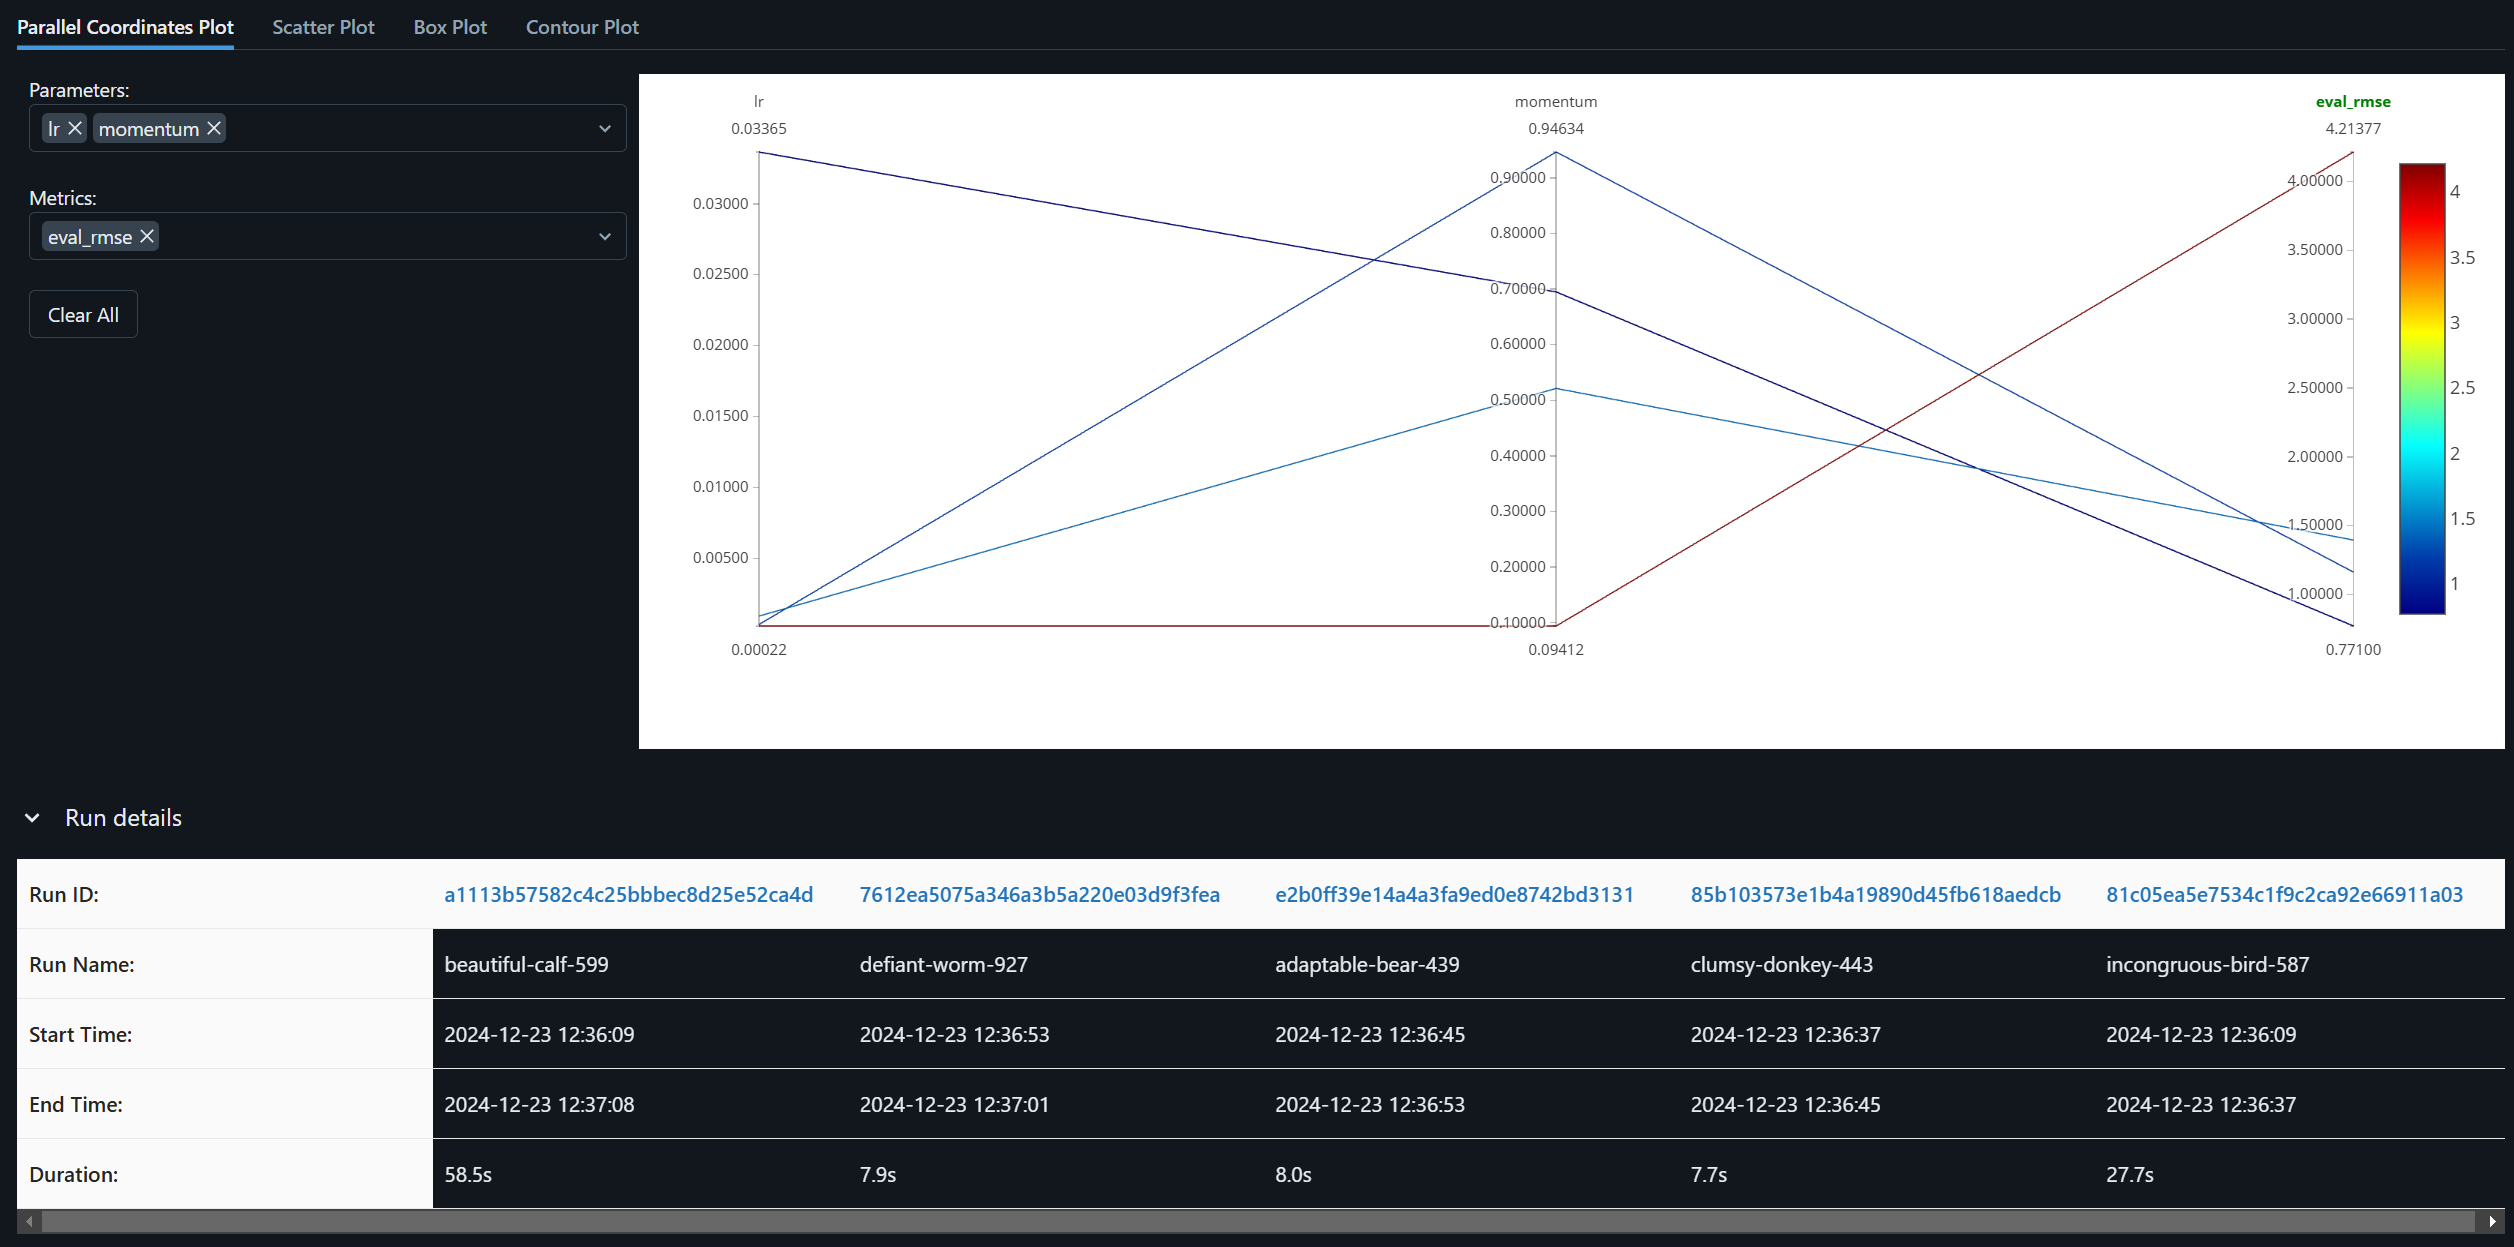

# choosing the best model

In [59]:
# inferencing 

from mlflow.models import validate_serving_input

model_uri = 'runs:/a1113b57582c4c25bbbec8d25e52ca4d/best_model'

# The logged model does not contain an input_example.
# Manually generate a serving payload to verify your model prior to deployment.
from mlflow.models import convert_input_example_to_serving_input

# Define INPUT_EXAMPLE via assignment with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
serving_payload = convert_input_example_to_serving_input(testx)

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[5.7136416],
       [5.1677136],
       [5.5990252],
       ...,
       [5.4838753],
       [5.392606 ],
       [5.266755 ]], dtype=float32)

In [61]:
# method 2 inferencing 
loaded_model=mlflow.pyfunc.load_model(model_uri)

import pandas as pd 
loaded_model.predict(pd.DataFrame(testx))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[5.7136416],
       [5.1677136],
       [5.5990252],
       ...,
       [5.4838753],
       [5.392606 ],
       [5.266755 ]], dtype=float32)